In [50]:
import meld_graph.experiment
import os
import numpy as np
import h5py
import matplotlib_surface_plotting as msp
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import nibabel as nb
from meld_classifier.paths import BASE_PATH
from meld_classifier.meld_cohort import MeldCohort,MeldSubject
def load_prediction(subject,hdf5,dset='prediction'):
    results={}
    with h5py.File(hdf5, "r") as f:
        for hemi in ['lh','rh']:
            results[hemi] = f[subject][hemi][dset][:]
    return results


In [51]:
model_path1 = '/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-02-09_MYCZ_baseline/s_2/'
model_path2 = '/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-01-13_QXFB_kernel_spiral_fold/s_2'
model_path_cls = '/home/kw350/software/gdl/meld_classifier_GDL/scripts/experiments_folder/23-02-09_MHYH_classification_deep/s_2/'
model_path_mask = '/home/kw350/software/gdl/meld_classifier_GDL/scripts/experiments_folder/23-02-09_MYCZ_mask_augmentation/s_2/'
model_path3 = '/rds/project/kw350/rds-kw350-meld/experiments/co-ripa1/iteration_21-09-15_nothresh/ensemble_21-09-15'

In [52]:
cohort = MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix_combat_6.hdf5',
               dataset='MELD_dataset_V6.csv')


In [196]:
folds = np.arange(5)

save_dirs = {
    'with_distance_loss': [os.path.join(model_path1,f'fold_0{fold}', 'results') for fold in np.arange(5)] ,
    'old_model': [os.path.join(model_path2,f'fold_0{fold}', 'results') for fold in np.arange(10)] ,
    'mask_aug': [os.path.join(model_path_mask,f'fold_0{fold}', 'results') for fold in np.arange(5)] ,
        'class': [os.path.join(model_path_cls,f'fold_0{fold}', 'results') for fold in np.arange(5)] ,

  #  'no_distance_loss': [os.path.join(model_path2,f'fold_0{fold}', 'results') for fold in folds] 
    
}

In [92]:
n_vert = len(cohort.cortex_label)*2

In [93]:
with h5py.File(os.path.join(save_dirs['with_distance_loss'][0], 'predictions.hdf5'), "r") as f:
    subjects = list(f.keys())


In [94]:
def roc_curves(subject_dictionary,roc_dictionary,roc_curves_thresholds):
    """calculate performance at multiple thresholds"""
    
    for t_i,threshold in enumerate(roc_curves_thresholds):
        predicted = subject_dictionary['result']>= threshold
        # if we want tpr vs fpr curve too
        # tp,fp,fn, tn = tp_fp_fn_tn(predicted, subject_dictionary['input_labels'])
        #store sensitivity and sensitivity_plus for each patient (has a label)
        if subject_dictionary['input_labels'].sum()>0:
            roc_dictionary['sensitivity'][t_i] += np.logical_and(predicted, subject_dictionary['input_labels']).any()
            roc_dictionary['sensitivity_plus'][t_i] += np.logical_and(predicted, subject_dictionary['borderzone']).any()
        #store specificity for controls (no label)
        else:
            roc_dictionary['specificity'][t_i] += ~predicted.any()

In [95]:
#number of tresholds to evaluate ROC curve, between 0 & 1.
n_thresh=101
roc_curves_thresholds=np.linspace(0,1,n_thresh)
roc_dictionary_base={'sensitivity':np.zeros(n_thresh),
'sensitivity_plus':np.zeros(n_thresh),
'specificity':np.zeros(n_thresh)}
roc_dictionary={}
for model_name in save_dirs.keys():
    roc_dictionary[model_name]={'sensitivity':np.zeros(n_thresh),
'sensitivity_plus':np.zeros(n_thresh),
'specificity':np.zeros(n_thresh)}



    for si,subj in enumerate(subjects):
        if si%100==0:
            print(si)
        s = MeldSubject(subj,cohort=cohort)
        labels_hemis = {}
        dists={}
        subject_results = np.zeros(n_vert)
        labels = np.zeros(n_vert)
        for hemi in ['lh','rh']:
            dists[hemi], labels_hemis[hemi] = s.load_feature_lesion_data(
                        features=['.on_lh.boundary_zone.mgh'], hemi=hemi, features_to_ignore=[]
                    )
            if np.sum(dists[hemi])==0:
                dists[hemi] +=200
        labels = np.hstack([labels_hemis['lh'][cohort.cortex_mask],labels_hemis['rh'][cohort.cortex_mask]])
        borderzones = np.vstack([dists['lh'][cohort.cortex_mask,:],dists['rh'][cohort.cortex_mask,:]]).ravel()<20
        n_folds = len(save_dirs[model_name])
        for fold in np.arange(n_folds):
            save_dir = save_dirs[model_name][fold]
            pred_file = os.path.join(save_dir, 'predictions.hdf5')
            result_hemis = load_prediction(subj,pred_file, dset='prediction')
            subject_results += np.hstack([result_hemis['lh']/n_folds,result_hemis['rh']/n_folds])
        subject_dictionary={'input_labels':labels,'borderzone':borderzones,'result':subject_results}
        roc_curves(subject_dictionary,roc_dictionary[model_name],roc_curves_thresholds)
    

0
100
200
300
400
0
100
200
300
400
0
100
200
300
400


In [96]:
file= os.path.join(model_path3,f'fold_all', 'results', 'predictions_ensemble_iteration_0.hdf5')
roc_dictionary['per vertex']={'sensitivity':np.zeros(n_thresh),
'sensitivity_plus':np.zeros(n_thresh),
'specificity':np.zeros(n_thresh)}
for si,subj in enumerate(subjects):
    

    if si%100==0:
        print(si)
    s = MeldSubject(subj,cohort=cohort)
    labels_hemis = {}
    dists={}
    subject_results = np.zeros(n_vert)
    labels = np.zeros(n_vert)
    for hemi in ['lh','rh']:
        dists[hemi], labels_hemis[hemi] = s.load_feature_lesion_data(
                    features=['.on_lh.boundary_zone.mgh'], hemi=hemi, features_to_ignore=[]
                )
        if np.sum(dists[hemi])==0:
            dists[hemi] +=200
    labels = np.hstack([labels_hemis['lh'][cohort.cortex_mask],labels_hemis['rh'][cohort.cortex_mask]])
    borderzones = np.vstack([dists['lh'][cohort.cortex_mask,:],dists['rh'][cohort.cortex_mask,:]]).ravel()<20
    # for fold in folds:
    #     save_dir = save_dirs['spiral'][fold]
    #     pred_file = os.path.join(save_dir, 'predictions.hdf5')
    #     result_hemis = load_prediction(subj,pred_file, dset='prediction')
    #     subject_results += np.hstack([result_hemis['lh']/10,result_hemis['rh']/10])
    result_hemis = load_prediction(subj,file, dset='prediction_raw')
    subject_results =np.hstack([result_hemis['lh'],result_hemis['rh']])
    subject_dictionary={'input_labels':labels,'borderzone':borderzones,'result':subject_results}
    roc_curves(subject_dictionary,roc_dictionary['per vertex'],roc_curves_thresholds)

0
100
200
300
400


In [97]:
def optimal_threshold(b,roc_curves_thresholds):
    sensitivity_curve = b['sensitivity_plus']/max(b['sensitivity_plus'])
    specificity_curve = b['specificity']/max(b['specificity'])
    youden = sensitivity_curve + specificity_curve
    optimal_thresh = np.max(np.where(youden==np.max(youden)))
    return sensitivity_curve,specificity_curve,optimal_thresh

In [98]:
import sklearn.metrics as metrics
def plot_roc(sensitivity_curve,specificity_curve,optimal_thresh,roc_curves_thresholds):
    fig, axes = plt.subplots(1,2)
    axes = axes.ravel()
    axes[0].plot(1-specificity_curve,sensitivity_curve,)
    #axes[0].scatter(1-specificity_curve[optimal_thresh],sensitivity_curve[optimal_thresh], c='r')
    axes[1].plot(roc_curves_thresholds,sensitivity_curve,label='sensitivity')
    axes[1].plot(roc_curves_thresholds,specificity_curve,label='specificity')
    axes[1].plot(roc_curves_thresholds,specificity_curve+sensitivity_curve-1,label='Youden')
   # axes[1].plot([roc_curves_thresholds[optimal_thresh],roc_curves_thresholds[optimal_thresh]],
   # [0,1],label='Optimal threshold')
    fig.legend()
    auc = metrics.auc(1-specificity_curve,sensitivity_curve)
    return fig

def plot_roc_multiple(roc_dictionary,roc_curves_thresholds):
    fig, ax = plt.subplots(1,1)   
    for mi,model in enumerate(roc_dictionary.keys()):
        sensitivity_curve,specificity_curve,optimal_thresh= optimal_threshold(roc_dictionary[model],
        roc_curves_thresholds=roc_curves_thresholds)
        ax.plot(1-specificity_curve,sensitivity_curve,label=model)
        auc = metrics.auc(1-specificity_curve,sensitivity_curve)
        ax.text(0,1-mi/10,f'{model} AUC: {auc:.2f}')
    fig.legend()
    return


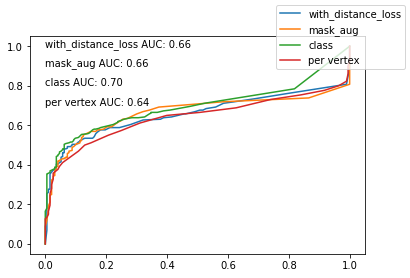

In [99]:
plot_roc_multiple(roc_dictionary,roc_curves_thresholds)

In [ ]:
#get optimal threshold. This might not be the best way to do it
sensitivity_curve,specificity_curve,optimal_thresh= optimal_threshold(roc_dictionary,roc_curves_thresholds=roc_curves_thresholds)
#this fixed value is what we used for iec.
f=plot_roc(sensitivity_curve,specificity_curve,optimal_thresh,roc_curves_thresholds)
print(sensitivity_curve[optimal_thresh],specificity_curve[optimal_thresh])

KeyError: 'sensitivity_plus'

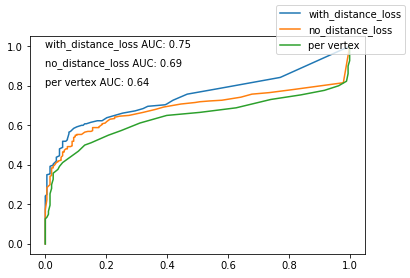

In [ ]:
plot_roc_multiple(roc_dictionary,roc_curves_thresholds)

In [232]:
import matplotlib_surface_plotting as msp
def load_predictions_for_subject(subj,savedirs,
        cohort,):
    #load mask
    s = MeldSubject(subj,cohort=cohort)
    hemi=s.get_lesion_hemisphere()
    dists, label = s.load_feature_lesion_data(
                    features=['.on_lh.boundary_zone.mgh'], hemi=hemi, features_to_ignore=[]
                )
    seg_pred = np.zeros(len(cohort.cortex_mask))
    dist_pred = np.zeros(len(cohort.cortex_mask))
    n_folds = 5
    folds = np.arange(n_folds)
    dp=[]
    sp = []
    for fold in folds:
        save_dir = save_dirs['mask_aug'][fold]
        pred_file = os.path.join(save_dir, 'predictions.hdf5')
        result_hemis = load_prediction(subj,pred_file, dset='prediction')
        seg_pred[cohort.cortex_mask] += result_hemis[hemi]/n_folds
        distance_map = load_prediction(subj,pred_file, dset='distance_map')
        dist_pred[cohort.cortex_mask] += distance_map[hemi]/n_folds
        dp.append(distance_map[hemi])
        sp.append(result_hemis[hemi])
    file = os.path.join(model_path3,f'fold_all', 'results', 'predictions_ensemble_iteration_0.hdf5')
    per_vertex = np.zeros(len(cohort.cortex_mask))
    per_vertex[cohort.cortex_mask] = load_prediction(subj,file, dset='prediction')[hemi]
    print(np.sum(np.logical_and(seg_pred>0.09,label>0)))
    return label,seg_pred,dist_pred,per_vertex,dp,sp
    

In [233]:
subj=subjects[114]

subj='MELD_H14_3T_FCD_0035'


In [234]:

label,seg_pred,dist_pred,per_vertex,dp,sp = load_predictions_for_subject(subj,save_dirs,cohort)
#msp.plot_surf(cohort.surf['coords'],cohort.surf['faces'],per_vertex)



500


In [235]:

for f in dp:
    print(np.max(f))


0.52254
-0.0002991458
0.106842004
0.14963639
0.20090598


In [236]:
def get_im():
    
    return

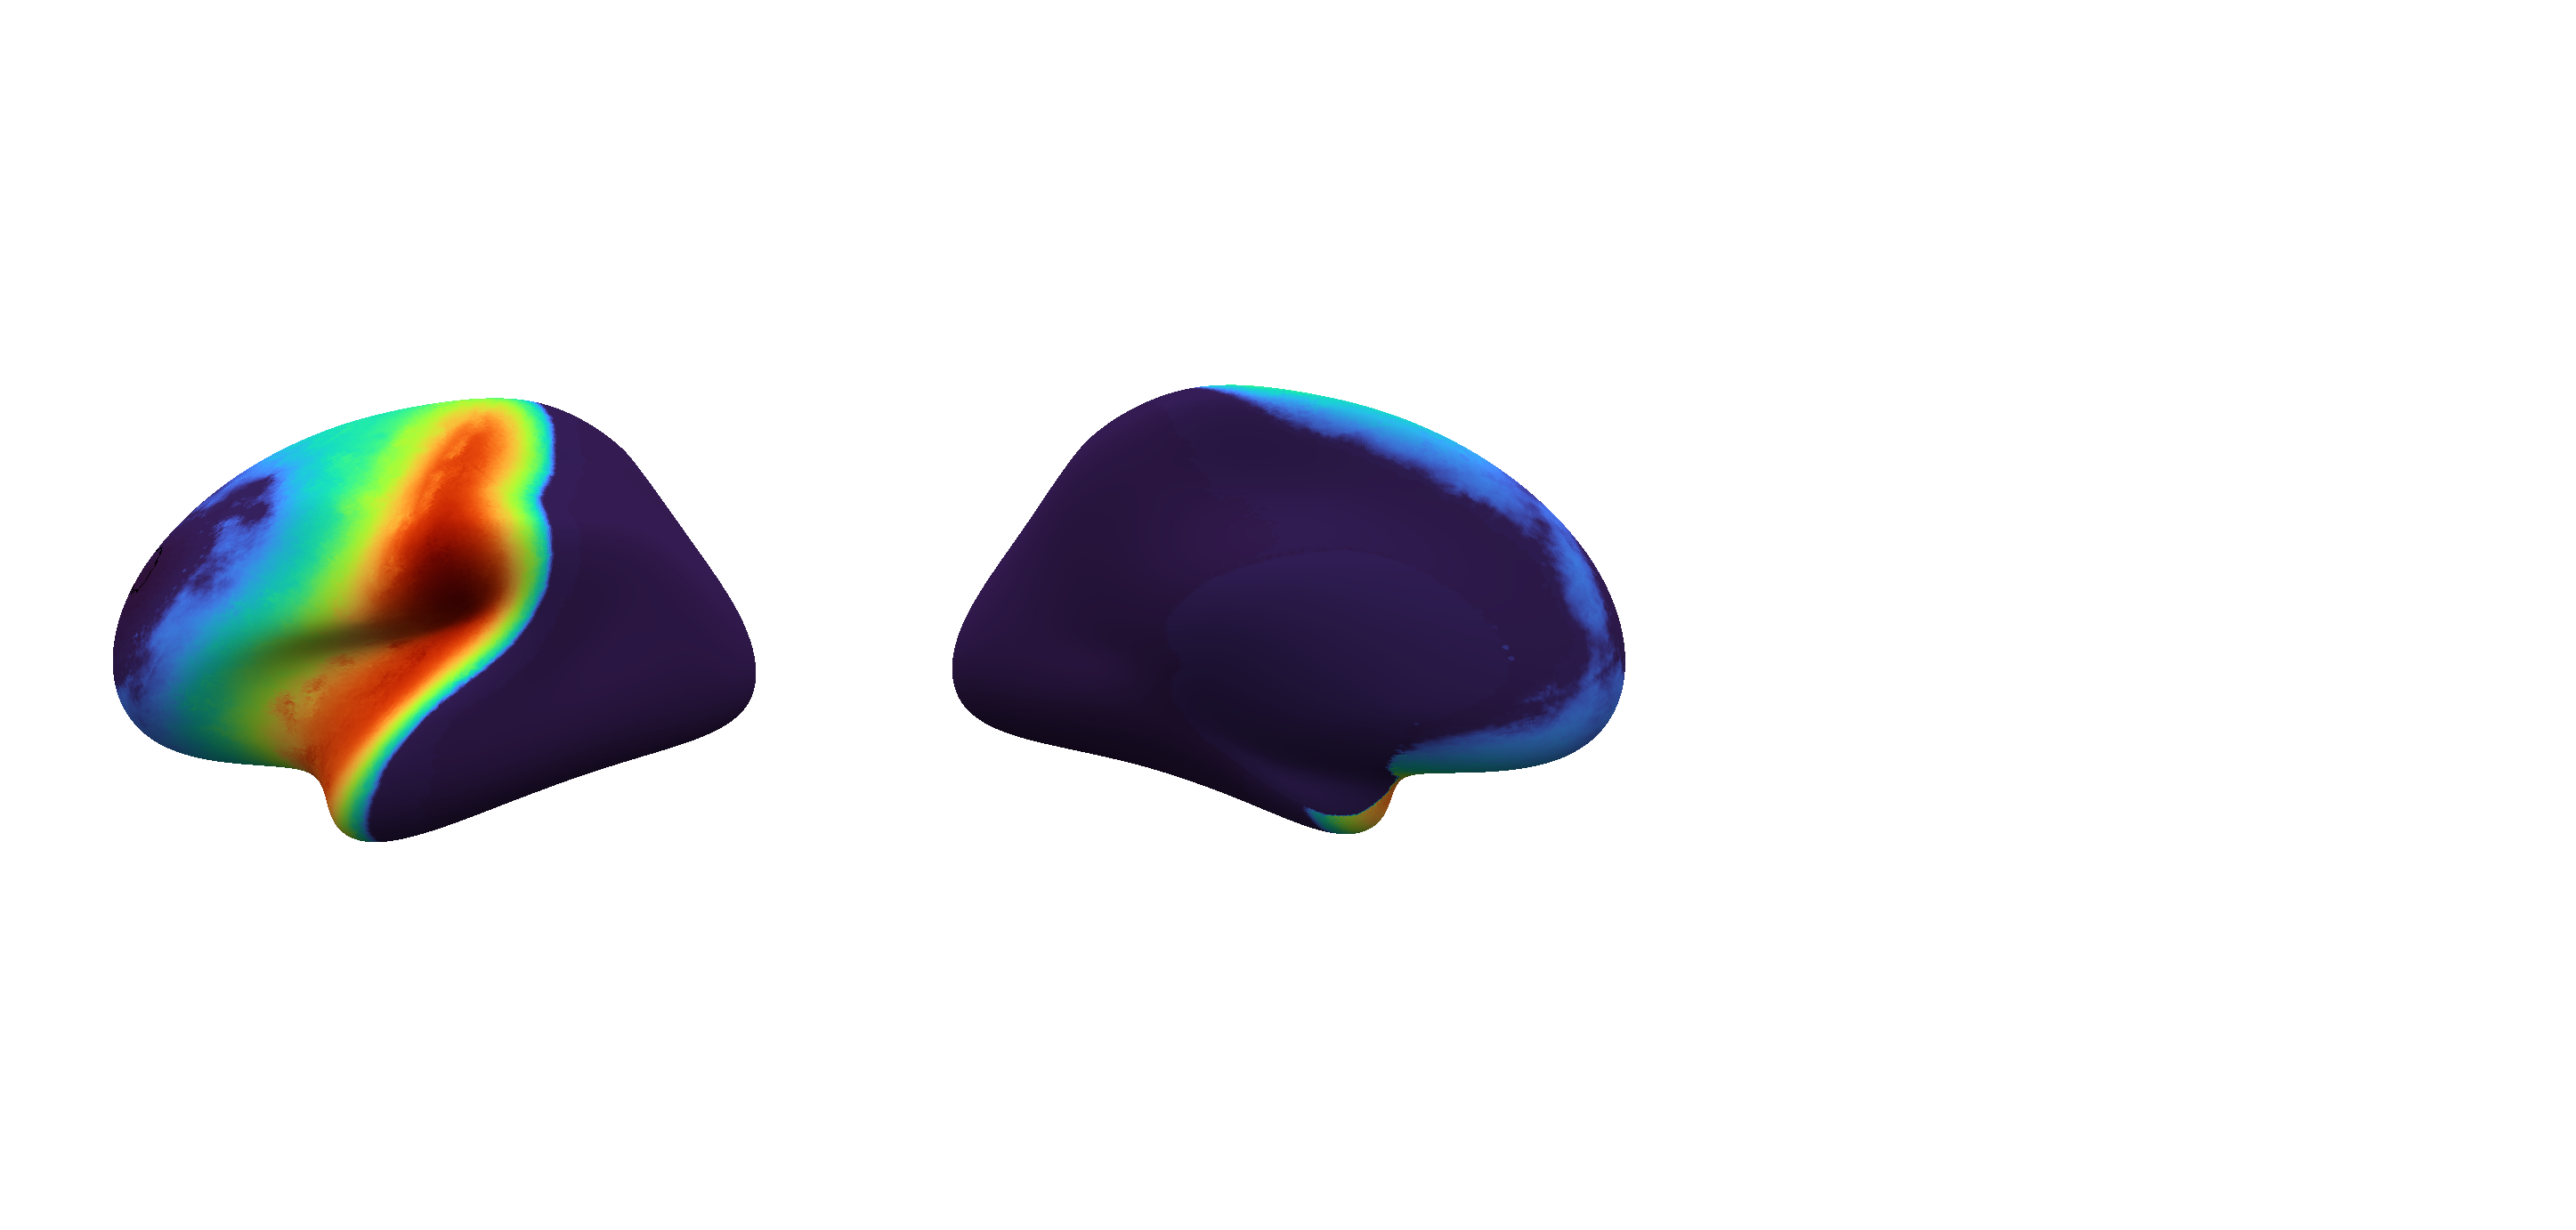

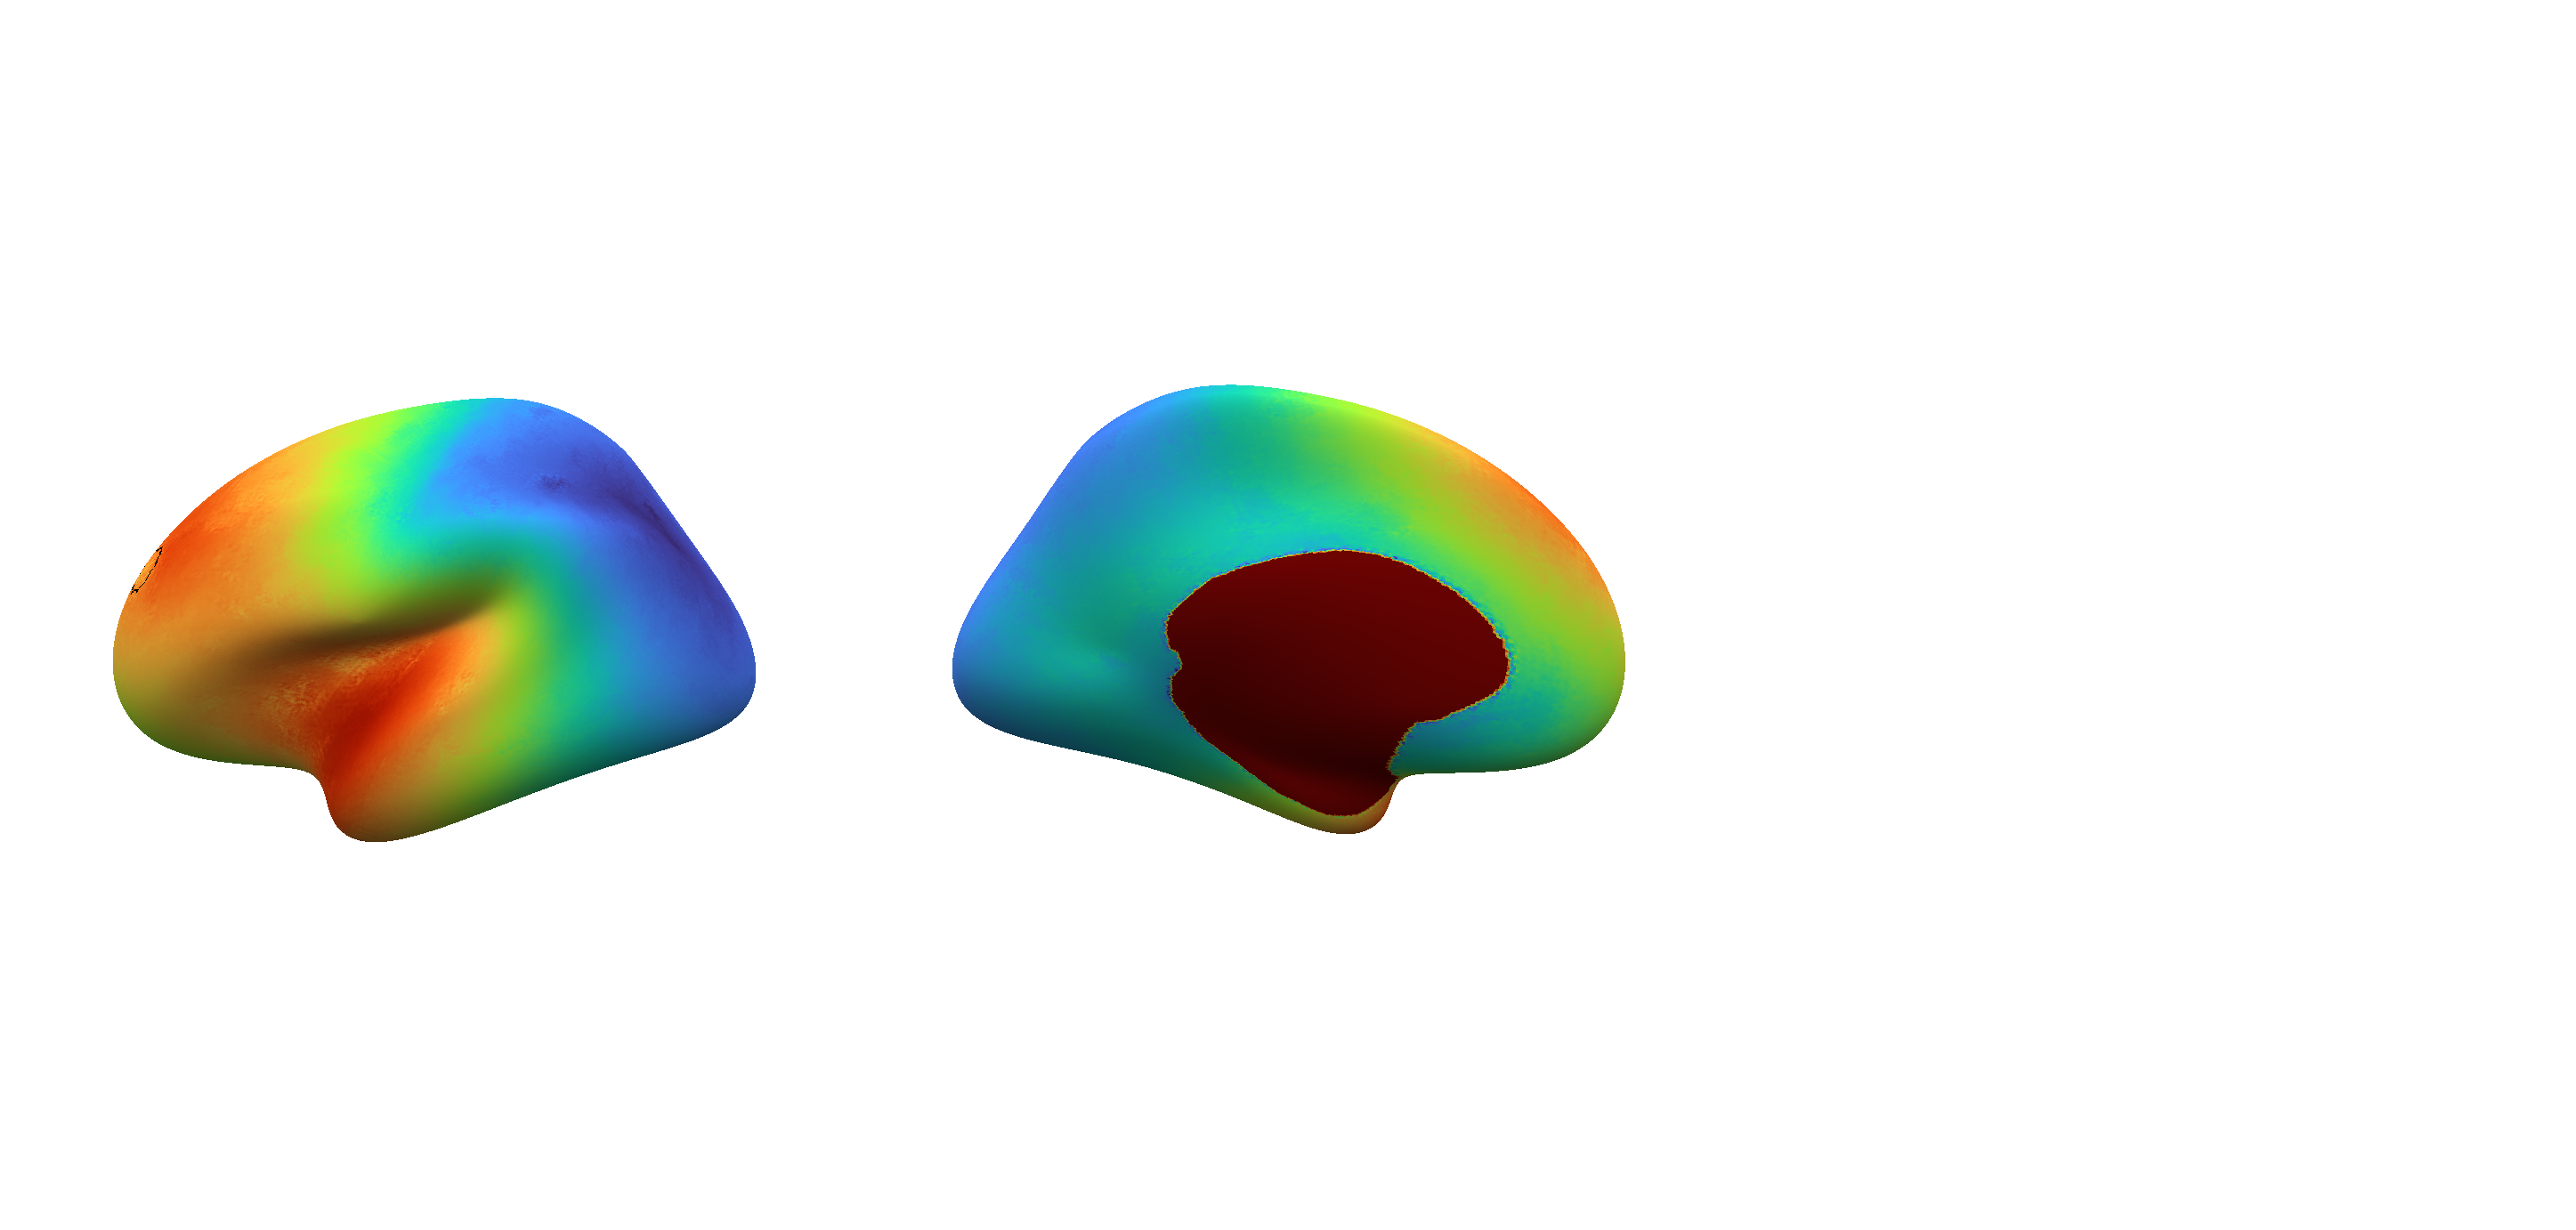

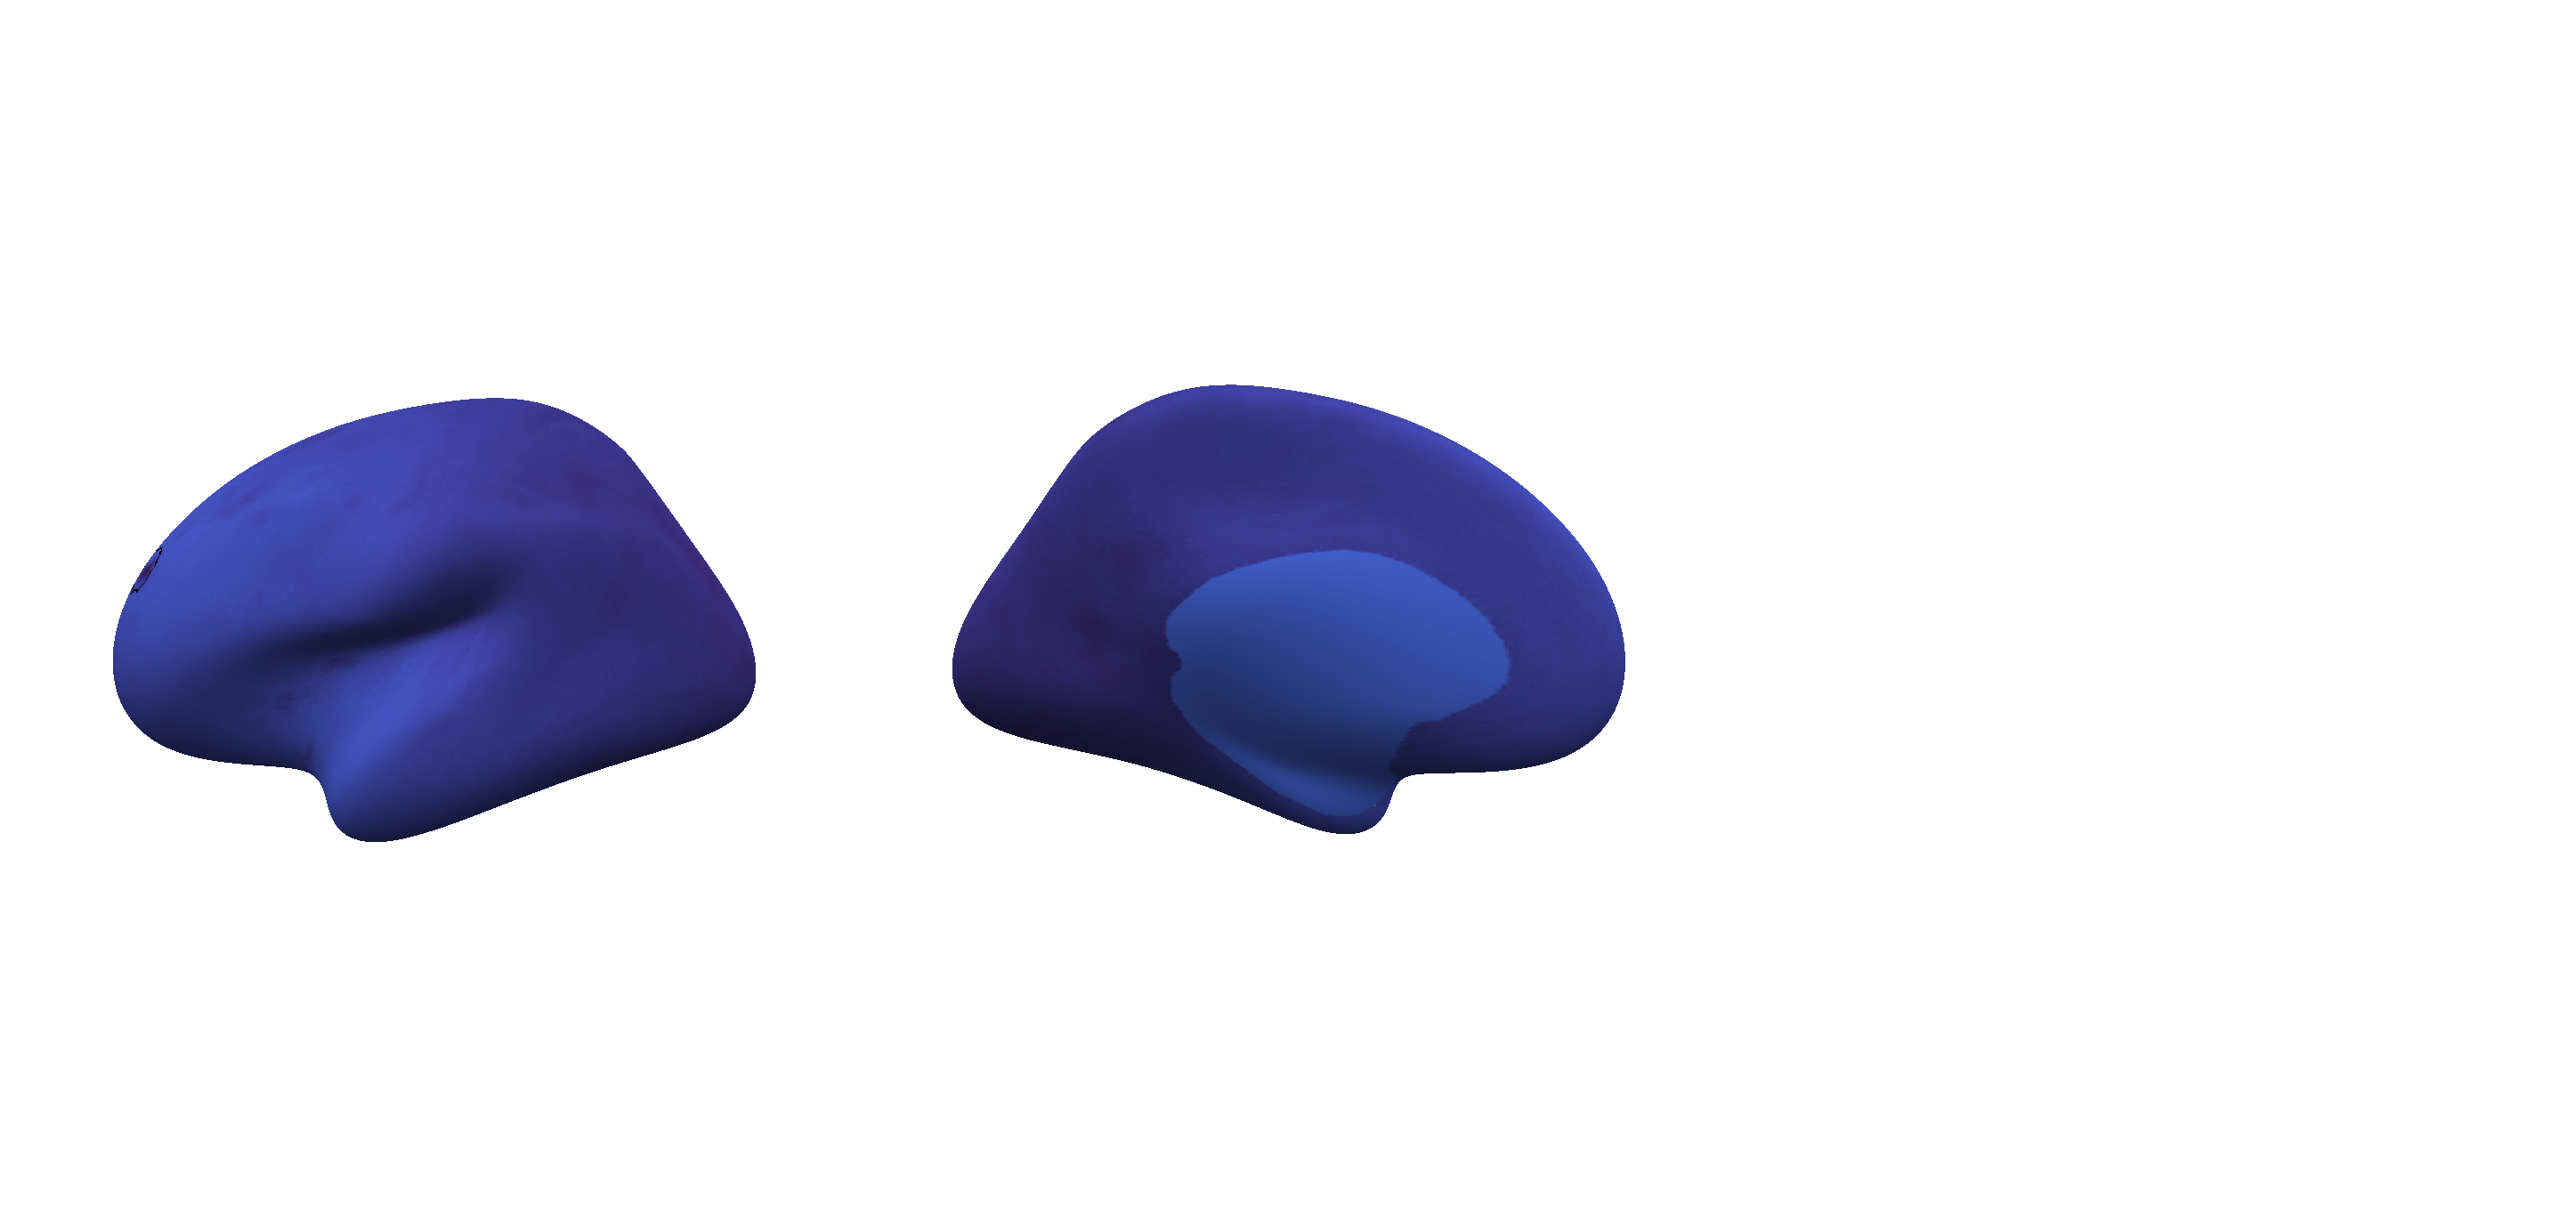

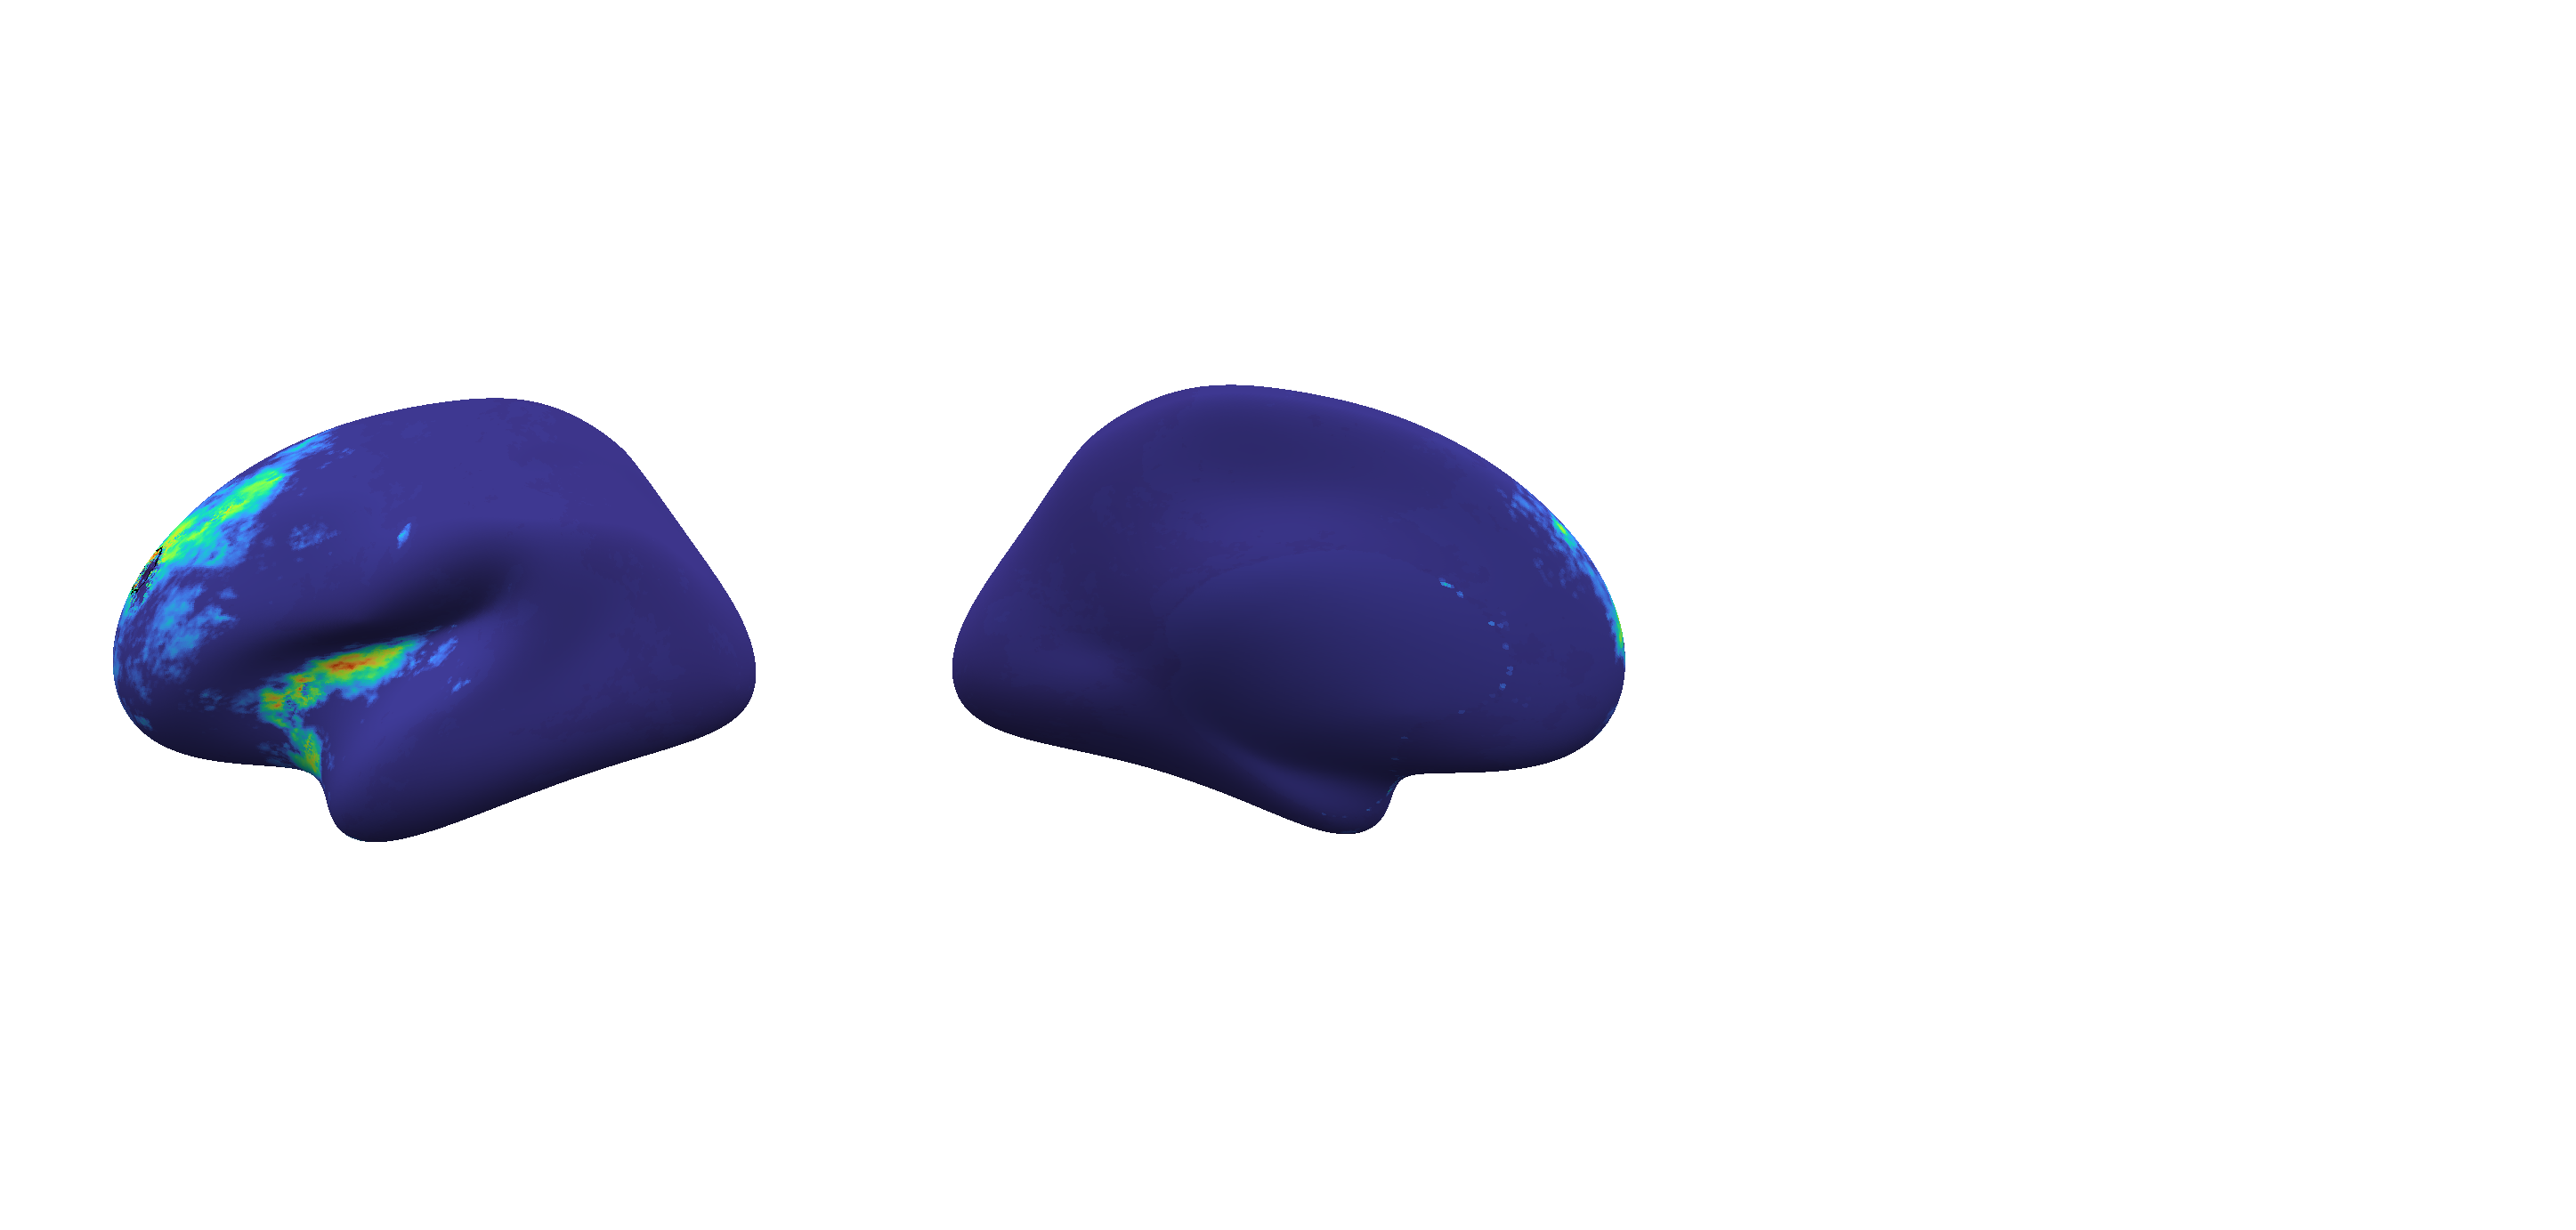

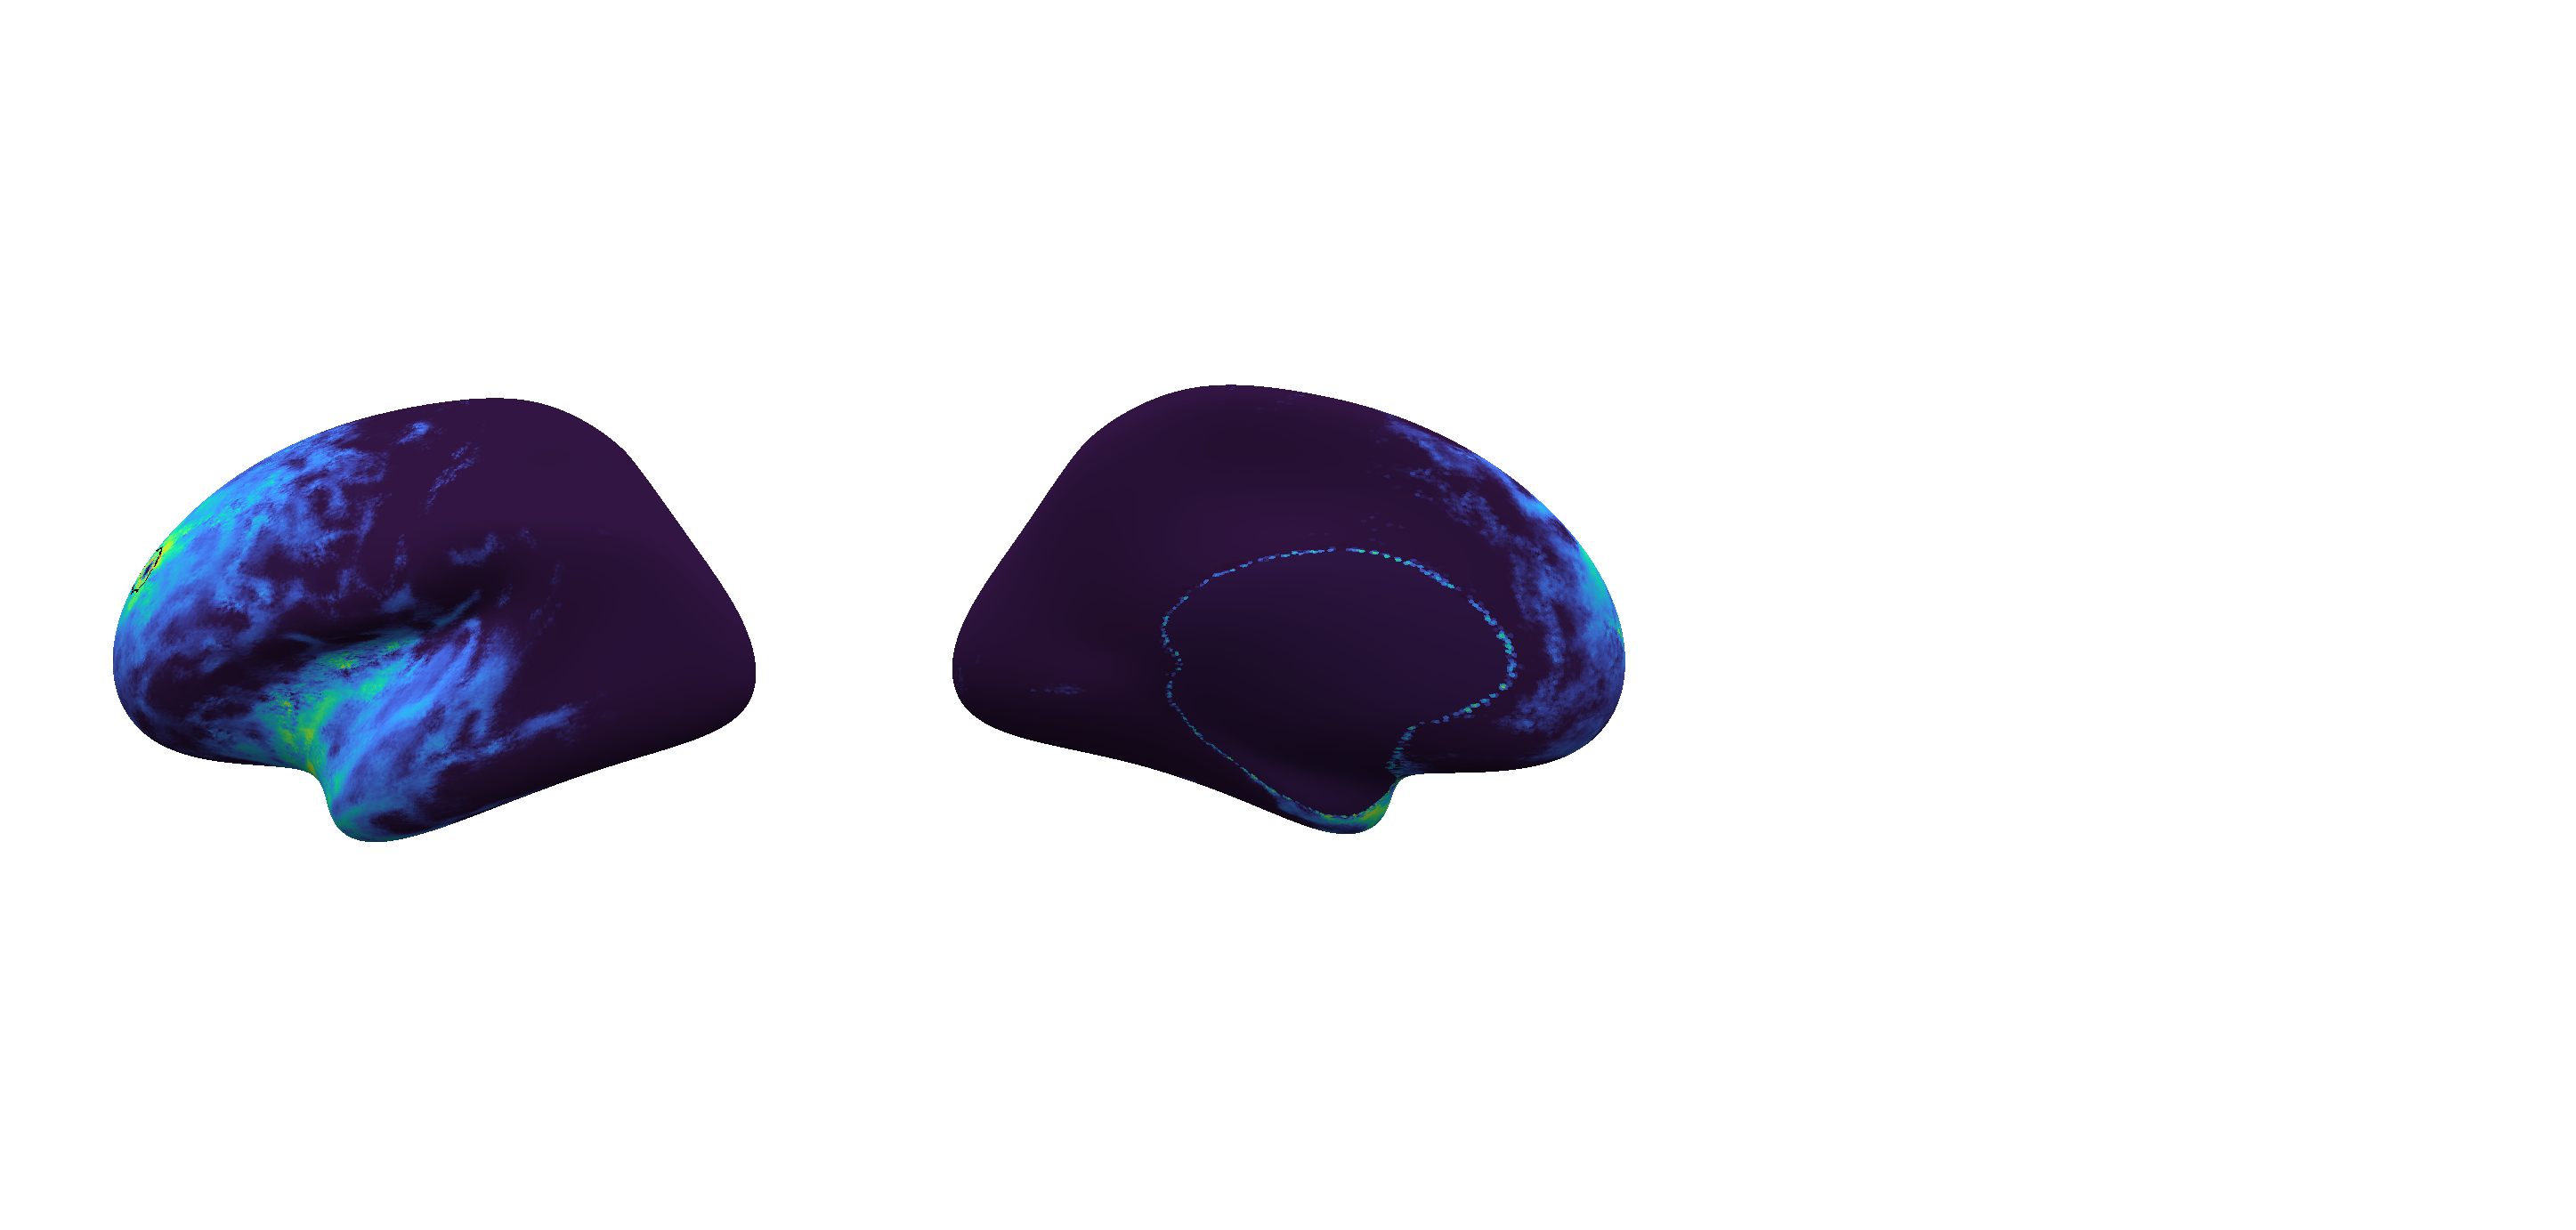

In [238]:
for d in dp:
    full_map = np.zeros(len(cohort.cortex_mask))
    full_map[cohort.cortex_mask]=d
    msp.plot_surf(cohort.surf['coords'],cohort.surf['faces'],full_map,#rotate=[90],
cmap='turbo',
base_size = 20,filename='tmp1.png', colorbar=False,#mask=~per_vertex,

parcel=label,parcel_cmap={0:[0,0,0,1],1:[0,0,0,1]})

In [230]:
per_vertex = per_vertex>0
from meld_classifier.meld_plotting import trim
from PIL import Image
msp.plot_surf(cohort.surf['coords'],cohort.surf['faces'],per_vertex,rotate=[90],
cmap='bwr',
base_size = 20,filename='tmp1.png', colorbar=False,mask=~per_vertex,
parcel=label,parcel_cmap={0:[0,0,0,1],1:[0,0,0,1]})
plt.close()
im = Image.open('tmp1.png')
trimmed_pv = trim(im)


In [209]:
seg_pred = seg_pred>0.5
msp.plot_surf(cohort.surf['coords'],cohort.surf['faces'],seg_pred,rotate=[90],
cmap='bwr',
base_size = 20,filename='tmp1.png', colorbar=False,mask=~seg_pred,
parcel=label,parcel_cmap={0:[0,0,0,1],1:[0,0,0,1]})
plt.close()
im = Image.open('tmp1.png')
trimmed_graph = trim(im)
msp.plot_surf(cohort.surf['coords'],cohort.surf['faces'],dist_pred,rotate=[90],
cmap='turbo',
base_size = 20,filename='tmp1.png', colorbar=False,#mask=~per_vertex,
parcel=label,parcel_cmap={0:[0,0,0,1],1:[0,0,0,1]})
plt.close()
im = Image.open('tmp1.png')
trimmed_dist = trim(im)



/home/kw350/.conda/envs/meld_graph/lib/python3.9/site-packages/matplotlib_surface_plotting/matplotlib_surface_plotting.py:326: RuntimeWarning: invalid value encountered in true_divide
  colours = (colours - colours.min())/(colours.max()-colours.min())


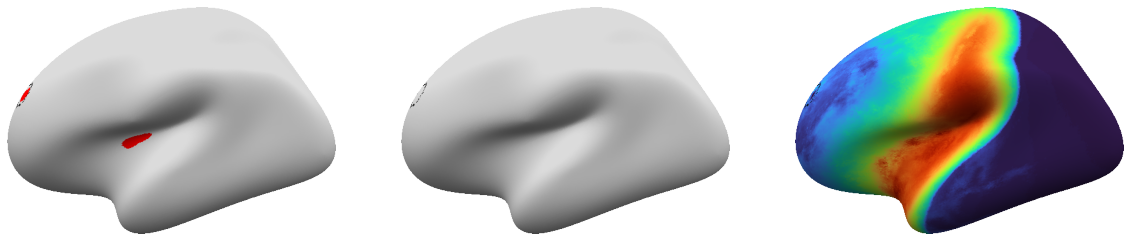

In [210]:
fig,ax = plt.subplots(1,3,figsize=(20,10))
ax[0].imshow(trimmed_pv)
ax[1].imshow(trimmed_graph)
ax[2].imshow(trimmed_dist)
for ax in ax:
    ax.axis('off')

In [ ]:
class EnsembleModel:
    def __init__(self, model_path):
        """model path doesn't contain the fold bit. this is then looped over"""
        #load models
        self.models=[]
        for fold in np.arange(10):
            fold_path = os.path.join(model_path,f'fold_0{fold}')
            exp = meld_graph.experiment.Experiment.from_folder(fold_path)
            exp.load_model(
                        checkpoint_path=os.path.join(fold_path, "best_model.pt"),
                        force=True,
                    )
            self.models.append(exp.model)
        self.network_parameters = exp.network_parameters

    def predict(self,data):
        """function to predict and average"""
        predictions=[]
        distance_maps=[]
        for model in self.models:
            estimates = model(data)
            predictions.append(torch.exp(estimates['log_softmax'])[:,1].numpy)
            #get distance map if exist in loss, otherwise return array of NaN
            if 'distance_regression' in self.network_parameters['training_parameters']['loss_dictionary'].keys():
                distance_map = estimates['non_lesion_logits'][:,0]
            else: 
                distance_map = torch.full((len(prediction),1), torch.nan)[:,0]
            distance_maps = 

In [ ]:
models=[]
for fold in np.arange(10):
    fold_path = os.path.join(model_path,f'fold_0{fold}')
    exp = meld_graph.experiment.Experiment.from_folder(fold_path)
    exp.load_model(
                checkpoint_path=os.path.join(fold_path, "best_model.pt"),
                force=True,
            )
    models.append(exp.model)

Initialised Experiment 23-01-13_QXFB_kernel_GMM_fold/s_2
Creating model
Loading model weights from checkpoint /rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-01-13_QXFB_kernel_GMM_fold/s_2/fold_00/best_model.pt
Initialised Experiment 23-01-13_QXFB_kernel_GMM_fold/s_2
Creating model
Loading model weights from checkpoint /rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-01-13_QXFB_kernel_GMM_fold/s_2/fold_01/best_model.pt
Initialised Experiment 23-01-13_QXFB_kernel_GMM_fold/s_2
Creating model
Loading model weights from checkpoint /rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-01-13_QXFB_kernel_GMM_fold/s_2/fold_02/best_model.pt
Initialised Experiment 23-01-13_QXFB_kernel_GMM_fold/s_2
Creating model
Loading model weights from checkpoint /rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-01-13_QXFB_kernel_GMM_fold/s_2/fold_03/best_model.pt
Initialised Experiment 23-01-13_QXFB_kernel_GMM_fold/s_2
Creating model
Loading model weights from check

NameError: name 'data' is not defined